In [1]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout
from vit_flow import VITAttentionFlow
import requests
import torch.nn.functional as F
import torch.nn as nn

In [10]:
img = Image.open("examples/input.png")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE}")

IMAGE_SIZE = 224
DISCARD_RATIO = 0.9

def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()
model.to(DEVICE)

Using cpu


Using cache found in /Users/francoisreynal/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

Using attention_flow


100%|██████████| 197/197 [11:30<00:00,  3.50s/it]


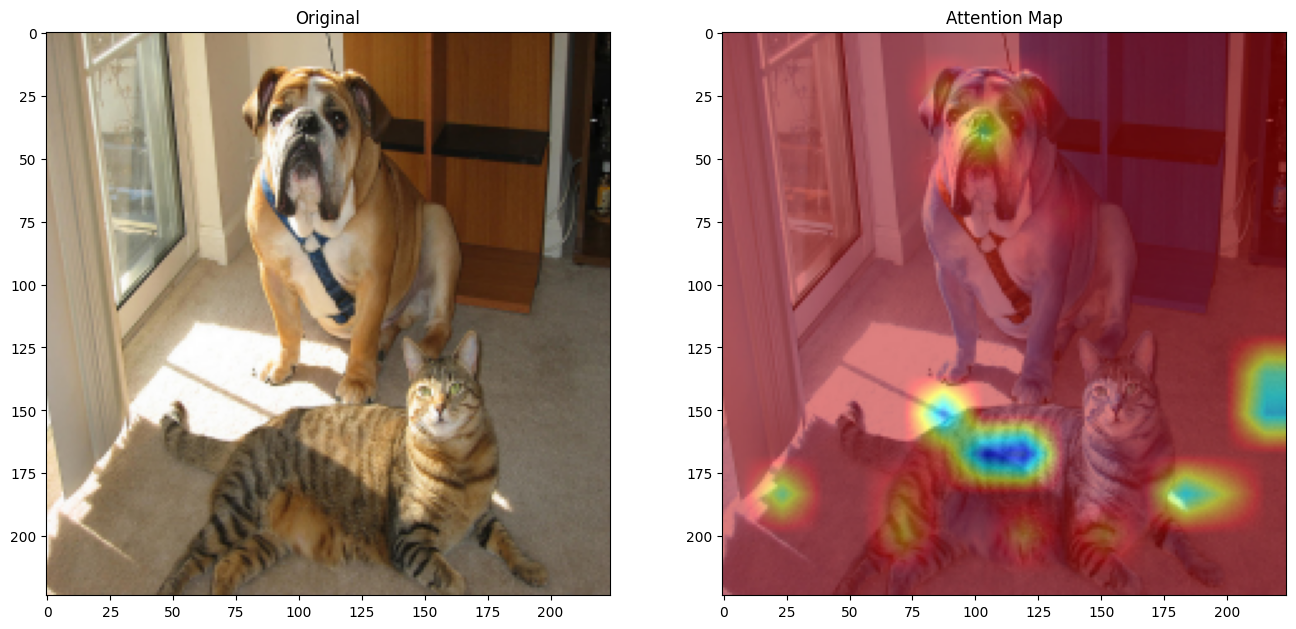

In [3]:
#@title Select the rollout strategy to be used and display results
#@markdown **Note** that for `grad_attention_rollout` passing a category index is mandatory.
rollout_strategy = "attention_flow" #@param ["attention_rollout", "grad_attention_rollout"]
category_index =  264#@param {type:"integer"}

print(f"Using {rollout_strategy}")

input_tensor  = preprocess_image("examples/input.png", transform)

if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")
    
elif rollout_strategy == "attention_flow":
    attention_flow = VITAttentionFlow(model, discard_ratio=DISCARD_RATIO)
    mask = attention_flow(input_tensor)
    name = "attention_flow_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

# mask = (mask - mask.min()) / (mask.max() - mask.min())
# mask = mask.clip(0.7,1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)

Using attention_flow


100%|██████████| 197/197 [10:35<00:00,  3.22s/it]


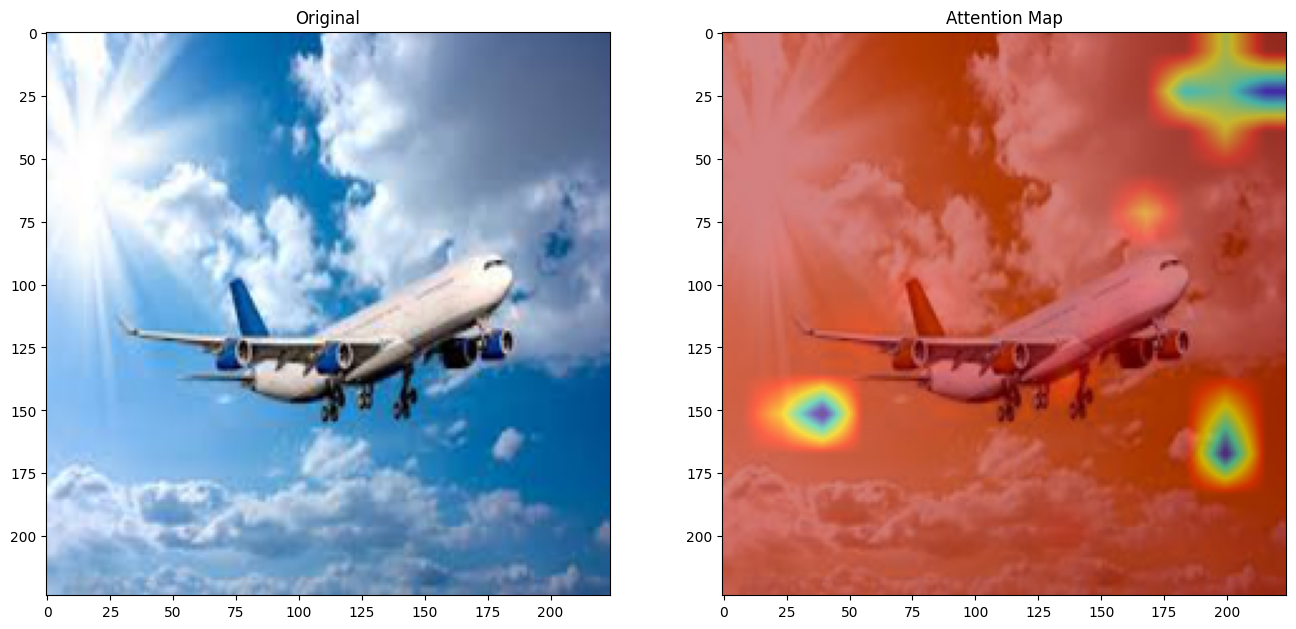

In [4]:
img=Image.open("examples/plane.png")
#@title Select the rollout strategy to be used and display results
#@markdown **Note** that for `grad_attention_rollout` passing a category index is mandatory.
rollout_strategy = "attention_flow" #@param ["attention_rollout", "grad_attention_rollout"]
category_index =  264#@param {type:"integer"}

print(f"Using {rollout_strategy}")

input_tensor  = preprocess_image("examples/plane.png", transform)

if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")
    
elif rollout_strategy == "attention_flow":
    attention_flow = VITAttentionFlow(model, discard_ratio=DISCARD_RATIO)
    mask = attention_flow(input_tensor)
    name = "attention_flow_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

# mask = (mask - mask.min()) / (mask.max() - mask.min())
# mask = mask.clip(0.7,1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)

## Attacks on the model
--------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


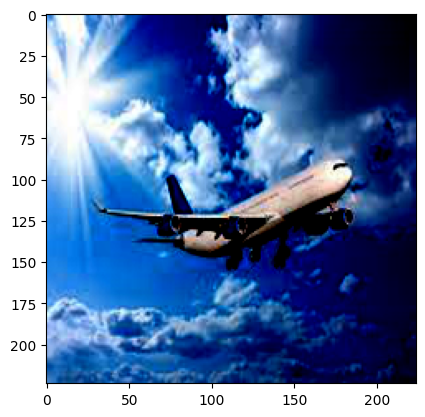

In [11]:
#Checking simple predictions of the model
LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
classes = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}

input_tensor  = preprocess_image("examples/plane.png", transform)
reshaped_image = np.squeeze(input_tensor)
reshaped_image = np.transpose(reshaped_image, (1, 2, 0))
plt.imshow(np.array(reshaped_image))


scores = model(input_tensor)

In [12]:
def print_preds(scores):
    # print the predictions with their 'probabilities' from the scores
    scores=scores.cpu()
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    # output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    return idx

_ = print_preds(scores)

0.304 -> ['n02690373', 'airliner']
0.084 -> ['n02692877', 'airship']
0.057 -> ['n04592741', 'wing']
0.055 -> ['n04552348', 'warplane']
0.034 -> ['n04266014', 'space_shuttle']


### Fast Gradient Sign Method Attack

In [16]:
#performing fgsm attack
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    grad_sign = torch.sign(data_grad)

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * grad_sign

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

idx = 656 #minivan
criterion = nn.CrossEntropyLoss()
input_tensor.requires_grad = True
scores = model(input_tensor)
scores=scores.cpu()
target = torch.tensor([idx])

#TODO: compute the loss to backpropagate
loss = criterion(scores, target)
loss.backward()

_ = print_preds(scores)

0.304 -> ['n02690373', 'airliner']
0.084 -> ['n02692877', 'airship']
0.057 -> ['n04592741', 'wing']
0.055 -> ['n04552348', 'warplane']
0.034 -> ['n04266014', 'space_shuttle']


### Gaussian Blur Attack: 

## Massive adversaries on differents images

### Notes sur les attaques

attaquer les zones ou les attentions sont concentrées

faire une boucle for et attaquer jusqu'a ce que la première prédiction change

prendre une matrice de bruit.
comparer par rapport aux méthodes

faire un rank de quels blocs est plus susceptible aux attaques???


fixer une zone initiale et faire

In [99]:
def get_best_prediction(scores):
    scores=scores.cpu()
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    return  classes[idx[0]]#, probs[idx[0]]  #get the highest score

def fgsm_attack(image, epsilon, data_grad):
    grad_sign = torch.sign(data_grad)

    mask = torch.ones(224, 224)
    mask[125:176, 15:66] = 0
    mask[125:185, 175:] = 0
    mask[0:80, 160:] = 0
    #mask[75:160, 30:200] = 0
    

    perturbed_image = image + epsilon * grad_sign * mask

    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

eps=0.01

def compute_one_attack(x_img,data_grad,epsilon=eps):
    return fgsm_attack(x_img,epsilon,data_grad)
    
def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)


def preprocess_tensor(image):
    
    return image.to(DEVICE)

['n02690373', 'airliner']
Class changed after 20 attacks.
['n02690373', 'airliner']


20

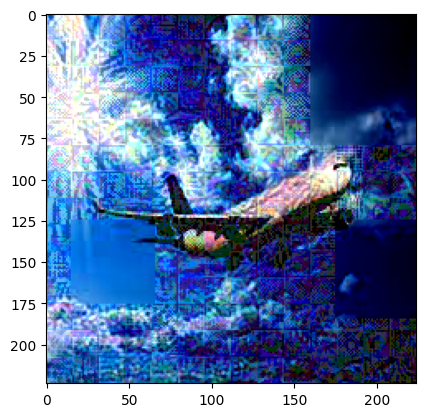

In [114]:
idx=280

def multiple_attacks(image, thresold=40):
    attack_number = 0
    img_tensor = preprocess_image("examples/plane.png", transform)
    img_tensor = img_tensor.requires_grad_(True)  # Ensure img_tensor is a leaf variable
    assumption = True
    scores = model(img_tensor)
    my_pred = get_best_prediction(scores)
    print(my_pred)
    target = torch.tensor([idx]).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(scores, target)
    loss.backward(retain_graph=True)  # Backpropagate the loss
    data_grad = img_tensor.grad.data
    

    while attack_number < thresold and assumption:
        
        model.zero_grad()
        img_tensor = compute_one_attack(img_tensor, data_grad)
        attack_number += 1
        criterion = nn.CrossEntropyLoss()
        img_tensor = img_tensor.requires_grad_(True)  # Ensure img_tensor is a leaf variable
        target = torch.tensor([idx]).to(DEVICE)
        scores = model(img_tensor)
        loss = criterion(scores, target)
        loss.backward(retain_graph=True)  # Backpropagate the loss
        #data_grad = img_tensor.grad.data
        new_best_prediction = get_best_prediction(scores)
        #print(new_best_prediction)
        if new_best_prediction == my_pred : #['n02692877', 'airship']
            assumption = True
        else:
            assumption = False

    print("Class changed after", attack_number, "attacks.")
    print( new_best_prediction)

    reshaped_image = np.squeeze(img_tensor.detach())
    reshaped_image = np.transpose(reshaped_image, (1, 2, 0))
    plt.imshow(np.array(reshaped_image))

    return attack_number

multiple_attacks(input_tensor)


In [76]:
key = next(key for key, value in classes.items() if value == ['n02692877', 'airship'])
key

405